In [1]:
import sympy as sp
import minterpy as mp
import numpy as np
from minterpy.pointcloud_utils import *

from mpl_toolkits import mplot3d
%matplotlib inline

from mpl_toolkits.mplot3d import axes3d

import torch
import torchvision
from torchvision import transforms, datasets

import random
import numpy as np
import matplotlib.pyplot as plt

import os
from operator import itemgetter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import ot

from sklearn.neighbors import NearestNeighbors

import ripser
import persim
from persim import plot_diagrams

from operator import itemgetter


#do pip installs as follows to use vedo for plotting point clouds
#pip install vedo
#pip install ipyvtklink

import numpy as np
from vedo import *

import matplotlib.pyplot
from mpl_toolkits.mplot3d import Axes3D

import time
torch.set_printoptions(precision=8)


In [2]:
def _compute_distance_matrix(x, p=2):
    x_flat = x.view(x.size(0), -1)

    distances = torch.norm(x_flat[:, None] - x_flat, dim=2, p=p)

    return distances

def get_persistence_diagram(point_cloud, maximum_dim):

    point_cloud = torch.tensor(point_cloud)

    dist_matrix = _compute_distance_matrix(point_cloud, p=2)
    diagrams = ripser.ripser(dist_matrix.cpu().detach().numpy(), distance_matrix=True, maxdim=maximum_dim)['dgms']
    return diagrams, plot_diagrams(diagrams, show=True)


def random_sampling_from_pt_cloud(point_cloud, req_sample_size):
    
    point_cloud = torch.tensor(point_cloud)

    idx = np.random.randint(point_cloud.shape[0], size=req_sample_size)

    random_Sampled_point_cloud = point_cloud[idx,:]

    return random_Sampled_point_cloud

In [3]:
x, y, z = sp.symbols('x y z')

expr = x**2 + y**2 + z**2 - 1
poly = sp.Poly(expr, x, y, z)

# convert sympy polynomial to minyterpy polynomial
newt_poly = sympy_to_mp(poly, mp.NewtonPolynomial)


#sample points
point_data = sample_points_on_poly(1000,        # Number of points to be sampled
                                   newt_poly,  # Polynomial in Newton basis
                                   bounds=1, # Boundary of the Cubic domain to be sampled
                                   tol=1e-15)  # Tolerance in solution

# Code for calculating zero dimensional persistence homology from scratch

In [4]:
# function to check whether the selected edge is going to close a potential loop

def expecting_a_cycle(actual_new_test, my_edge):

    left_ind = my_edge[0][0]
    right_ind = my_edge[0][1]
    found_right_ind = False
    going_nowhere= False

    new_test = actual_new_test

    tracker = 0
    no_branches_formed = True
    while (not(found_right_ind) or not(going_nowhere)):

        positions1 = (new_test == left_ind).nonzero(as_tuple=False)

        if(positions1.shape[0]>1):
            edge_to_delete = new_test[positions1[0][0]]
            no_branches_formed = False
        
        branches_rising = positions1.shape[0]

        if(positions1.shape[0]==0):
            going_nowhere= True
            if(no_branches_formed):
                break
            
            left_ind = my_edge[0][0]

            deletable_edge_position1 = (actual_new_test == edge_to_delete[0]).nonzero(as_tuple=False)
            deletable_edge_position2 = (actual_new_test == edge_to_delete[1]).nonzero(as_tuple=False)

            deletable_edge_position1 = deletable_edge_position1[:,0]

            deletable_edge_position2 = deletable_edge_position2[:,0]

            a_cat_b1, counts1 = torch.cat([deletable_edge_position1, deletable_edge_position2]).unique(return_counts=True)
            deletable_row_position = a_cat_b1[torch.where(counts1.gt(1))]

            if(deletable_row_position.shape[0]==0):
                going_nowhere = True
                break

            deletable_row_position = deletable_row_position[0]

            actual_new_test = torch.cat((actual_new_test[:deletable_row_position], actual_new_test[deletable_row_position+1:]))
            new_test = actual_new_test

            positions1 = (new_test == left_ind).nonzero(as_tuple=False)

            if(tracker ==0):
                break

        if(positions1.shape[0]>1):
            edge_to_delete = new_test[positions1[0][0]]
            no_branches_formed = False
                
        first_position = positions1[0][0]
        adj_edge1 = new_test[positions1[0][0]]
        other_end1 = abs(positions1 - torch.tensor([[0, 1]]))


        consec_pt1 = new_test[other_end1[0][0]][other_end1[0][1]]
        consec_pt1 = int(consec_pt1)

        if(consec_pt1 == right_ind):
            found_right_ind = True
            break

        else:
            left_ind = consec_pt1
            new_test = torch.cat((new_test[:first_position], new_test[first_position+1:]))
            tracker = tracker+1
    
    return found_right_ind



In [5]:
def get_zero_dim_persistent_homology(dist_matrix):
    
    dist_matrix = torch.unique(dist_matrix, dim=0)
    dist_matrix = torch.unique(dist_matrix, dim=1)

    upp_diag = torch.triu(dist_matrix, diagonal=1)

    ff = upp_diag.sort()

    sorted_upper_diag_edges = ff[0]

    sorted_upper_diag_indices = ff[1]

    flattened_uppdg_edges = torch.flatten(sorted_upper_diag_edges)

    non_zero_flattened_uppdg_edges = flattened_uppdg_edges[flattened_uppdg_edges.nonzero()]

    non_zero_flattened_uppdg_edges = non_zero_flattened_uppdg_edges.reshape(non_zero_flattened_uppdg_edges.shape[0])

    increasing_edges = non_zero_flattened_uppdg_edges.sort()[0]
    increasing_edges = torch.unique(increasing_edges, dim=0)

    selected_edges = torch.tensor([])
    dead_indices = torch.tensor([])
    potential_triangles = torch.tensor([])
    edge_leads_to_loop = False

    for i in range(increasing_edges.shape[0]):
        a = (upp_diag == increasing_edges[i]).nonzero(as_tuple=False)

        if(selected_edges.shape[0] > 1):
            edge_leads_to_loop = expecting_a_cycle(selected_edges, a)

        if(not(edge_leads_to_loop)):
            selected_edges = torch.cat(((selected_edges, a)), 0)


    zeroD_PH = torch.tensor([])
    for i in range(selected_edges.shape[0]):    
        death = dist_matrix[int(selected_edges[i][0])][int(selected_edges[i][1])]
        death = death.reshape(1,1)    
        zeroD_PH = torch.cat(((zeroD_PH, death)), 0)

    births = torch.zeros(zeroD_PH.shape[0], 1)
    zeroD_PH_births_deaths = torch.cat((births, zeroD_PH ),1)

    return zeroD_PH_births_deaths

    

In [6]:
random_pts = random_sampling_from_pt_cloud(point_data, 80)

In [7]:
distance_matrix = _compute_distance_matrix(random_pts, p=2)


In [8]:
start = time.time()

zero_d_PH = get_zero_dim_persistent_homology(distance_matrix)

end = time.time()

print(f"Runtime of the program is {end - start}")

Runtime of the program is 24.019785165786743


In [9]:
zero_d_PH

tensor([[0.00000000, 0.04540188],
        [0.00000000, 0.06368485],
        [0.00000000, 0.06947888],
        [0.00000000, 0.07684732],
        [0.00000000, 0.07722051],
        [0.00000000, 0.08519725],
        [0.00000000, 0.09049034],
        [0.00000000, 0.09644984],
        [0.00000000, 0.09940679],
        [0.00000000, 0.10355505],
        [0.00000000, 0.11155246],
        [0.00000000, 0.11514364],
        [0.00000000, 0.12201690],
        [0.00000000, 0.12551710],
        [0.00000000, 0.12904695],
        [0.00000000, 0.13194135],
        [0.00000000, 0.13259140],
        [0.00000000, 0.14323154],
        [0.00000000, 0.15702309],
        [0.00000000, 0.15734965],
        [0.00000000, 0.16560978],
        [0.00000000, 0.16989433],
        [0.00000000, 0.17405440],
        [0.00000000, 0.17667376],
        [0.00000000, 0.18551660],
        [0.00000000, 0.18752589],
        [0.00000000, 0.18801247],
        [0.00000000, 0.19014981],
        [0.00000000, 0.19158014],
        [0.000

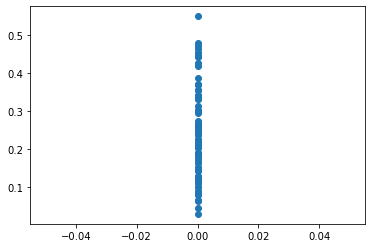

In [10]:
# plotting PH calculated from scratch

x = zero_d_PH[:,0]
y = zero_d_PH[:,1]

plt.scatter(x,y)

# Using ripser

In [11]:
start = time.time()

diagrams = ripser.ripser(distance_matrix.cpu().detach().numpy(), distance_matrix=True, maxdim=2)['dgms']

end = time.time()

print(f"Runtime of the program is {end - start}")
diagrams[0]

Runtime of the program is 0.06536602973937988


array([[0.        , 0.0283059 ],
       [0.        , 0.04519818],
       [0.        , 0.06153768],
       [0.        , 0.06409436],
       [0.        , 0.07712252],
       [0.        , 0.08331768],
       [0.        , 0.0865557 ],
       [0.        , 0.08988588],
       [0.        , 0.09802037],
       [0.        , 0.09890433],
       [0.        , 0.10975647],
       [0.        , 0.11186673],
       [0.        , 0.11228801],
       [0.        , 0.11952674],
       [0.        , 0.12558903],
       [0.        , 0.12657684],
       [0.        , 0.12841332],
       [0.        , 0.14084148],
       [0.        , 0.14688984],
       [0.        , 0.15270007],
       [0.        , 0.1633231 ],
       [0.        , 0.16908996],
       [0.        , 0.17875923],
       [0.        , 0.18259254],
       [0.        , 0.1884007 ],
       [0.        , 0.18846485],
       [0.        , 0.18874696],
       [0.        , 0.20297313],
       [0.        , 0.20438451],
       [0.        , 0.20712258],
       [0.

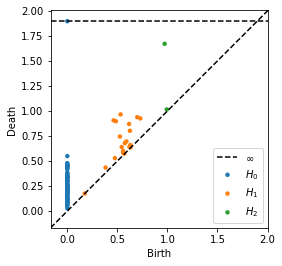

In [12]:
plot_diagrams(diagrams, show=True)

# Checking the correctness

In [13]:
for i in range(zero_d_PH.shape[0]):
    print("No. ",i)
    print(abs(zero_d_PH[i] - diagrams[0][i]) <= 10**(-3) )

No.  0
tensor([True, True])
No.  1
tensor([True, True])
No.  2
tensor([True, True])
No.  3
tensor([True, True])
No.  4
tensor([True, True])
No.  5
tensor([True, True])
No.  6
tensor([True, True])
No.  7
tensor([True, True])
No.  8
tensor([True, True])
No.  9
tensor([True, True])
No.  10
tensor([True, True])
No.  11
tensor([True, True])
No.  12
tensor([True, True])
No.  13
tensor([True, True])
No.  14
tensor([True, True])
No.  15
tensor([True, True])
No.  16
tensor([True, True])
No.  17
tensor([True, True])
No.  18
tensor([True, True])
No.  19
tensor([True, True])
No.  20
tensor([True, True])
No.  21
tensor([True, True])
No.  22
tensor([True, True])
No.  23
tensor([True, True])
No.  24
tensor([True, True])
No.  25
tensor([True, True])
No.  26
tensor([True, True])
No.  27
tensor([True, True])
No.  28
tensor([True, True])
No.  29
tensor([True, True])
No.  30
tensor([True, True])
No.  31
tensor([True, True])
No.  32
tensor([True, True])
No.  33
tensor([True, True])
No.  34
tensor([True, Tr